In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix,f1_score
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
import itertools as it
import time as time
import xgboost as xgb

In [2]:
column_names=[
    'age', 'class', 'ind_code_det', 'occ_code_det', 'education', 'wage_hr', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'cap_gain', 'cap_loss', 'dividend', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'inst_weight', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'num_ppl_worked', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'weeks_worked', 'year', 'income']

In [3]:
data = pd.read_csv('../data/census-income.data', header=None)
data = data.replace('?', np.nan)
data = data.replace(' ?', np.nan)
data.columns=column_names
data.shape

(199523, 42)

In [4]:
missing_values = pd.DataFrame({'Count': data.isnull().sum()})
missing_values.sort_index(inplace=True)
missing_values

,Count
age,0
birth_dad,6713
birth_mom,6119
birth_self,3393
cap_gain,0
cap_loss,0
citizenship,0
class,0
dividend,0
education,0


In [5]:
data.drop(['migr_change_msa','migr_change_reg','migr_move_msa','migr_sunbelt'],axis = 1,inplace=True)
data.dropna(inplace=True)

In [6]:
data.shape

(190561, 38)

In [7]:
train = data.copy()
train['income'] = train['income'].apply(lambda x: 1 if x == ' 50000+.' else 0)

In [8]:
categorical_predictors = [
    'class', 'ind_code_det', 'occ_code_det', 'education', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'lived_1yr', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'year']

In [9]:
le = LabelEncoder()
for pred in categorical_predictors:
    train[pred] = le.fit_transform(train[pred])
train.head(2)

,age,class,ind_code_det,occ_code_det,education,wage_hr,enroll_edu,marital,ind_code_maj,occ_code_maj,...,birth_dad,birth_mom,birth_self,citizenship,employed_status,veteran_admin,veteran_benefit,weeks_worked,year,income
0,73,3,0,0,12,0,2,6,14,6,...,39,39,39,4,0,1,2,0,1,0
1,58,6,4,34,16,0,2,0,4,8,...,39,39,39,4,0,1,2,52,0,0


In [10]:
test = pd.read_csv('../census-income.test',header=None)
test.columns=column_names
test.drop(['migr_change_msa','migr_change_reg','migr_move_msa','migr_sunbelt'],axis = 1,inplace=True)
test.dropna(inplace=True)

test['income'] = test['income'].apply(lambda x: 1 if x == ' 50000+.' else 0)
for pred in categorical_predictors:
    test[pred] = le.fit_transform(test[pred])
test.head(2)

,age,class,ind_code_det,occ_code_det,education,wage_hr,enroll_edu,marital,ind_code_maj,occ_code_maj,...,birth_dad,birth_mom,birth_self,citizenship,employed_status,veteran_admin,veteran_benefit,weeks_worked,year,income
0,38,4,6,36,3,0,2,2,10,5,...,26,26,26,0,0,1,2,12,1,0
1,44,6,37,12,8,0,2,2,2,10,...,40,40,40,4,0,1,2,26,1,0


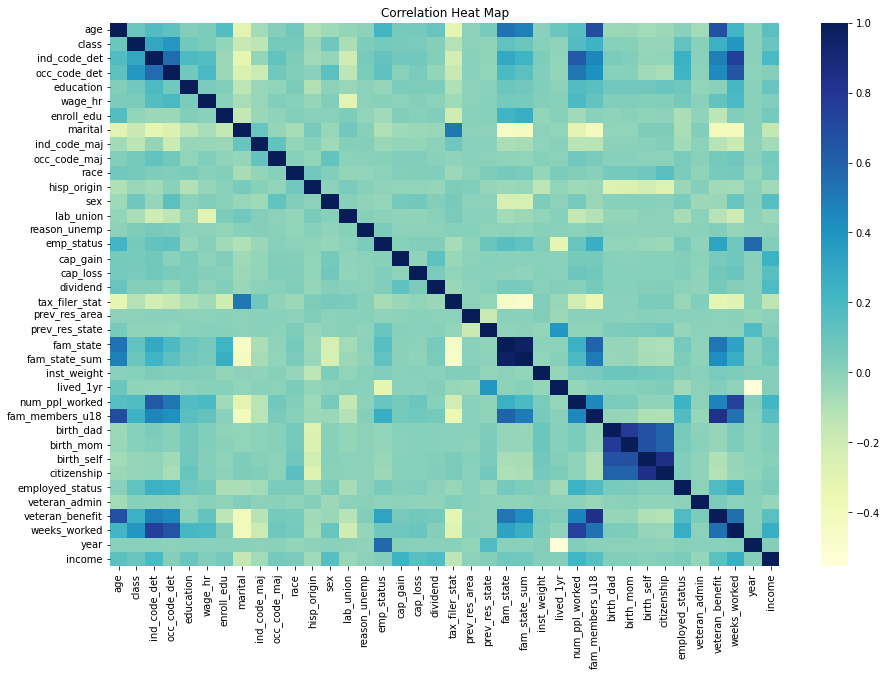

In [11]:
correlation_matrix = train.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, cmap="YlGnBu")
plt.title("Correlation Heat Map")
plt.show()

- accuracy + recall

In [12]:
X_train = train.drop(['income'],axis = 1)
y_train = train.income
X_test = test.drop(['income'],axis = 1)
y_test = test.income
X_train.shape

(190561, 37)

In [13]:
#sum(negative instances) / sum(positive instances)
(y_train.shape[0]-y_train.sum())/y_train.sum()

15.347344942952732

- The scale_pos_weight hyperparameter in XGBoost is used to address class imbalance in the training data. It controls the balance of positive and negative weights in the boosting process.
- If we increase the value of scale_pos_weight, the model will focus on classifying positives more correctly. This will increase the recall (true positive rate) since the focus is on identifying all positives. However, this will lead to identifying positives aggressively, and observations ‘similar’ to observations of the positive class will also be predicted as positive resulting in an increase in false positives and a decrease in precision. See the trend below as we increase the value of scale_pos_weight.
- For our case, this hyperparameter is set to 15

# Model Development

In [105]:
def decision_threshold(model):
    threshold_hyperparam_vals = np.arange(0, 1.01, 0.01)

    predicted_class = cross_val_predict(model, X_train, y_train, cv=5)
    predicted_probability = model.predict_proba(X_train)

    results = []

    for threshold_prob in threshold_hyperparam_vals:
        predicted_class = (predicted_probability[:,1] > threshold_prob).astype(int)
        accuracy = accuracy_score(y_true=y_train,y_pred=predicted_class)
        recall = recall_score(y_true=y_train,y_pred=predicted_class)
        results.append({'Threshold': threshold_prob, 'Accuracy': accuracy, 'Recall': recall})
    df_results=pd.DataFrame(results)
    return df_results

def model_performance(model_opt,opt_threshold):
    train_predictions = (model_opt.predict_proba(X_train)[:, 1] > opt_threshold).astype(int)
    test_predictions = (model_opt.predict_proba(X_test)[:, 1] > opt_threshold).astype(int)

    train_accuracy = accuracy_score(y_true=y_train, y_pred=train_predictions)
    train_recall = recall_score(y_true=y_train, y_pred=train_predictions)
    test_accuracy = accuracy_score(y_true=y_test, y_pred=test_predictions)
    test_recall = recall_score(y_true=y_test, y_pred=test_predictions)

    print("Training accuracy:", train_accuracy)
    print("Training recall:", train_recall)
    print("Test accuracy:", test_accuracy)
    print("Test recall:", test_recall)

In [122]:
start_time = time.time()
param_grid = {'max_depth': [8],
              'learning_rate': [0.01, 0.1],
              'reg_lambda': [0,1],
              'n_estimators': [500,700],
              'gamma': [0,1],
              'subsample': [0.3,0.5],
              'colsample_bytree':[0.5],
              'scale_pos_weight': [15]}

cv = KFold(n_splits=2, shuffle=True)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBClassifier(objective = 'binary:logistic'),
                                    param_distributions=param_grid,
                                    verbose=1,
                                    n_jobs=-1,
                                    scoring='accuracy',
                                    cv=cv)
optimal_params.fit(X_train, y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation score =", optimal_params.best_score_) 
print("Time taken =", round((time.time() - start_time) / 60), " minutes")

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Optimal parameter values = {'subsample': 0.5, 'scale_pos_weight': 15, 'reg_lambda': 1, 'n_estimators': 700, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.5}
Optimal cross validation score = 0.938523617921839
Time taken = 7  minutes


In [124]:
model1 = xgb.XGBClassifier(objective='binary:logistic',max_depth = 8, learning_rate = 0.1,n_estimators = 700,
                           reg_lambda = 1, gamma = 1, subsample = 0.5,scale_pos_weight=15).fit(X_train,y_train)
df1 = decision_threshold(model1)

In [125]:
filtered_df1 = df1[(df1['Accuracy'] >= 0.95) & (df1['Recall'] >= 0.80)]
filtered_df1

,Threshold,Accuracy,Recall
34,0.34,0.950997,1.000000
35,0.35,0.952503,1.000000
36,0.36,0.953978,1.000000
37,0.37,0.955411,1.000000
38,0.38,0.956817,1.000000
39,0.39,0.958197,1.000000
40,0.40,0.959436,1.000000
41,0.41,0.960616,1.000000
42,0.42,0.961870,1.000000
43,0.43,0.962962,1.000000


In [107]:
model_performance(model1,0.64)

Training accuracy: 0.9369178373329275
Training recall: 0.8837608304023333
Test accuracy: 0.9351757182093382
Test recall: 0.7379566763659877


In [102]:
model2 = xgb.XGBClassifier(objective='binary:logistic',max_depth = 10, learning_rate = 0.01,n_estimators = 700,
                           reg_lambda = 1, gamma = 1, subsample = 0.3,scale_pos_weight=15).fit(X_train,y_train)
df2 = decision_threshold(model2)

In [111]:
filtered_df2 = df2[(df2['Accuracy'] >= 0.9) & (df2['Recall'] >= 0.85)]
filtered_df2.sort_values('Recall',ascending=False)

,Threshold,Accuracy,Recall
49,0.49,0.901407,0.933259
50,0.50,0.903669,0.929399
51,0.51,0.905778,0.925195
52,0.52,0.907715,0.920477
53,0.53,0.909672,0.917217
54,0.54,0.911687,0.912499
55,0.55,0.913650,0.907867
56,0.56,0.915597,0.903063
57,0.57,0.917386,0.899288
58,0.58,0.919254,0.894570


In [114]:
model_performance(model2,0.49)

Training accuracy: 0.901406898578408
Training recall: 0.9332589860169855
Test accuracy: 0.9041518814779175
Test recall: 0.8388296152602651


In [123]:
#grid search of model 8

start_time = time.time()
param_grid = {'max_depth': [8],
              'learning_rate': [0.01,0.1],
              'reg_lambda': [1,10],
              'n_estimators': [1000],
              'gamma': [1,10],
              'subsample': [0.5],
              'colsample_bytree':[0.5],
              'scale_pos_weight': [15]}

cv = KFold(n_splits=2, shuffle=True)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBClassifier(objective = 'binary:logistic'),
                                    param_distributions=param_grid,
                                    verbose=1,
                                    n_jobs=-1,
                                    scoring='accuracy',
                                    cv=cv)
optimal_params.fit(X_train, y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation score =", optimal_params.best_score_) 
print("Time taken =", round((time.time() - start_time) / 60), " minutes")

Fitting 2 folds for each of 8 candidates, totalling 16 fits


/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Optimal parameter values = {'subsample': 0.5, 'scale_pos_weight': 15, 'reg_lambda': 1, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.5}
Optimal cross validation score = 0.9444115011908168
Time taken = 10  minutes


In [126]:
model8x = xgb.XGBClassifier(objective='binary:logistic',max_depth = 8, learning_rate = 0.1,n_estimators = 1000,
                           reg_lambda = 1, gamma = 1, subsample = 0.5, colsample_bytree=0.5, scale_pos_weight=15).fit(X_train,y_train)
df8x = decision_threshold(model8x)

In [127]:
filtered_df8x = df8x[(df8x['Accuracy'] >= 0.9) & (df8x['Recall'] >= 0.80)]
filtered_df8x.sort_values('Recall',ascending=False)

,Threshold,Accuracy,Recall
12,0.12,0.902435,1.000000
27,0.27,0.945472,1.000000
40,0.40,0.964127,1.000000
39,0.39,0.962931,1.000000
38,0.38,0.961897,1.000000
...,...,...,...
88,0.88,0.990029,0.895942
89,0.89,0.989389,0.879043
90,0.90,0.988403,0.857425
91,0.91,0.987248,0.831346


In [ ]:
model_performance(model8x,)

In [80]:
model8 = xgb.XGBClassifier(objective='binary:logistic',max_depth = 8, learning_rate = 0.01,n_estimators = 1000,
                           reg_lambda = 10, gamma = 10, subsample = 0.5, colsample_bytree=0.5, scale_pos_weight=15).fit(X_train,y_train)
df8 = decision_threshold(model8)

In [81]:
filtered_df8 = df8[(df8['Accuracy'] >= 0.9) & (df8['Recall'] >= 0.80)]
filtered_df8.sort_values('Recall',ascending=False)

,Threshold,Accuracy,Recall
56,0.56,0.901989,0.902719
57,0.57,0.904272,0.899116
58,0.58,0.906450,0.894055
59,0.59,0.908675,0.889852
60,0.60,0.910727,0.884962
61,0.61,0.913067,0.880329
62,0.62,0.915119,0.874753
63,0.63,0.917323,0.868834
64,0.64,0.919595,0.863087
65,0.65,0.921610,0.856653


In [128]:
model_performance(model8,0.56)

Training accuracy: 0.9019893892244478
Training recall: 0.9027193960710302
Test accuracy: 0.9139151179807943
Test recall: 0.8333333333333334


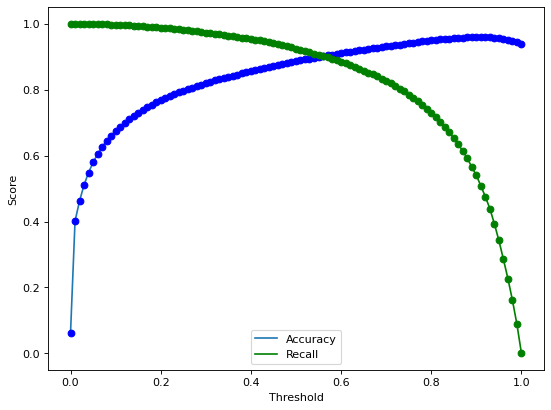

In [92]:
plt.figure(figsize=(8,6),dpi=80)
plt.plot(df8['Threshold'],df8['Accuracy'],label='Accuracy')
plt.plot(df8['Threshold'],df8['Accuracy'],'o',color='blue')
plt.plot(df8['Threshold'],df8['Recall'],label='Recall',color='green')
plt.plot(df8['Threshold'],df8['Recall'],'o',color='green')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()

In [94]:
importance = list(model8.feature_importances_)
name = list(model8.feature_names_in_)
df = pd.DataFrame()
df['Feature Name'] = name
df['Feature Importance'] = importance
df.sort_values(by='Feature Importance', ascending=False).head(10)

,Feature Name,Feature Importance
35,weeks_worked,0.141849
12,sex,0.116196
26,num_ppl_worked,0.089708
27,fam_members_u18,0.075187
3,occ_code_det,0.053904
18,dividend,0.048249
16,cap_gain,0.043300
0,age,0.038543
22,fam_state,0.036015
23,fam_state_sum,0.035576



- An accuracy score of 91 means that the model correctly predicted 91% of all instances (both positive and negative) in the dataset.
- A recall score of 83 means that the model correctly identified 83% of the positive instances (true positives) out of all the actual positive instances in the dataset.

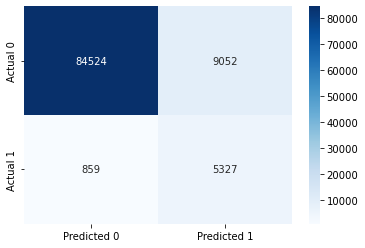

In [104]:
y_pred8 = model8.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred8), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');